<div class="title">组件深入</div>

1. props
1. 组件事件(Component events)
1. Fallthrough Attributes
1. 插槽(Slots)
1. Provide/inject
1. Async Components

# props
## prop参数声明
prop属性用于给子组件**实例**传递参数，需要在组件的props选项中声明
- 该声明可以类比构造函数的形参，用于构造（实例化）子组件实例
- 我们也可以称prop属性为prop参数

```js
export default {
  props: ['foo'],  // prop参数声明，一个字符串数组，每个字符串是一个参数名称
  created() {
    // props are exposed on `this`
    console.log(this.foo)
  }
}
```
在组件中，需要用`this`来访问该参数，因为该参数是组件实例的，不是组件的 (类比在c++的类方法中访问成员变量）

除了字符串数组外，props选项还可以是一个Object
```js
export default {
  props: {
    title: String,
    likes: Number
  }
}
```
该props Object中，每个属性对应一个参数
- 属性名称是参数名称，属性值是参数类型（本质上是参数类型的构造函数）
- 参数类型可以使得组件的参数更容易理解，还可以做prop类型验证（使用者传递错误的参数类型会触发警告）

## prop参数传递细节
prop参数名称是一个字符串，理论上任意的字符串都可以用。为了方便，一般用camelCase(驼峰法）命名。

```js
export default {
  props: {
    greetingMessage: String //声明时，作为属性名称，驼峰法名称写起来方便，不需要双引号
  }
}
```
```html
<span>{{ greetingMessage }}</span>

<!-- 在非In-DOM写法中，驼峰法名称也可以直接写，不过习惯上还是会转换成连字符法（在In-DOM写法中则必须转换）-->
<MyComponent greeting-message="hello" /> 
```

在可以的情况下，组件名称标签尽量用PascalCase写法，并且写成自关闭标签，这样可以提高易读性，很容易区分自定义Vue组件和原生的html元素。但是参数传递没有这样的好处。

## 静态 vs. 动态 props
参数传递是在组件实例化时，以设置html属性的方式进行的。既然是html属性设置，那么可以是静态，也可以是动态
- 静态时会解析成字符串
- 动态时会解析成JS表达式（将引号内部看作JS代码）

```html
<BlogPost title="My journey with Vue" />

<!-- Dynamically assign the value of a variable -->
<BlogPost :title="post.title" />

<!-- Dynamically assign the value of a complex expression -->
<BlogPost :title="post.title + ' by ' + post.author.name" />
```

## 参数类型
参数的类型不限于字符串类型，可以是任意JS类型，例如布尔类型
```html
<!-- 参数若是没有值，默认为 `true`. -->
<BlogPost is-published />

<!--  注意这里需要用动态绑定，否则会解析成字符串 -->
<BlogPost :is-published="false" />

<!-- 动态绑定到某个变量上 -->
<BlogPost :is-published="post.isPublished" />
```

例如数组、对象
```html
<BlogPost :comment-ids="[234, 266, 273]" />

<BlogPost :comment-ids="post.commentIds" />
<BlogPost
  :author="{
    name: 'Veronica',
    company: 'Veridian Dynamics'
  }"
 />

<BlogPost :author="post.author" />
```

`v-bind`（动态绑定）可以不带参数，用来同时绑定多个属性（之前学的是html自带属性，这里的prop属性也可以）

```js
export default {
  data() {
    return {
      post: {
        id: 1,
        title: 'My Journey with Vue'
      }
    }
  }
}
```
以下两种绑定是等价的
```html
<BlogPost v-bind="post" />
<BlogPost :id="post.id" :title="post.title" />
```

## 单向数据流动
prop参数传递是一种单向数据绑定
- 响应性：若父组件的实参发生变化，传到子组件中的形参也会相应的更新
- 单向：反过来，改变子组件中的形参不会影响父组件的实参

注意：父组件的每次更新都会使得子组件的形参更新，因此改变子组件中的形参没有意义（Vue会在控制台中发出警告）
```js
export default {
  props: ['foo'],
  created() {
    // ❌ warning, props are readonly!
    this.foo = 'bar'
  }
}
```

然而，经常会出现让人想在子组件中改变prop参数的情形
1. prop参数用作一个初始值来初始化子组件，随后子组件想将该prop属性当作一个普通的本地数据属性
    - 这种情形下，可以将prop参数赋值给另一个本地变量
    
```js
export default {
  props: ['initialCounter'],
  data() {
    return {
      // 这里只将prop参数 this.initialCounter 当作一个初始值
      // 将该参数值赋值给另一个变量，可以断开与prop参数的绑定
      counter: this.initialCounter
    }
  }
}
```

2. prop参数当作一个原始值，该值需要做一些转换
    - 这种情形下，可以使用计算属性
    
 ```js
export default {
  props: ['size'],
  computed: {
    // computed property that auto-updates when the prop changes
    normalizedSize() {
      return this.size.trim().toLowerCase()
    }
  }
}
```

注意，以上所说的（在子组件中）改变prop参数是指改变prop参数本身，不包括改变prop参数的内部属性。

换句话说，如果prop参数是Array或Object类型，那么是可以（在子组件中）改变prop参数的。这是因为JS的Array和Object是引用传递，如果Vue想防止这种深层次的改变会有很大的开销，因此不会发生警告，需要作者自行避免。

这种深层次改变会造成不好的结果：子组件会在父组件的不知情的情况下，改变父组件的状态，可能会触发其它意料之外的更新（尤其是在该状态是响应式状态的情况下）。

最好的方法是：
- 避免这种改变，除非想故意使得父组件与子组件紧密地耦合。
- 子组件应该发出(emit)一个事件给父组件，让父组件来改变

## prop参数验证
组件可以指定对参数的要求
- 例如之前讲的参数的类型
- 若是要求没满足，Vue会在控制台发生警告（development模式下）
- 参数验证是在组件实例创建之前，不能使用组件的属性（例如`data`,`computed`）

```js
export default {
  props: {
    // 基本的类型验证
    //  (`null` 和 `undefined` 允许所有类型)
    propA: Number,
    // 多个允许的类型
    propB: [String, Number],
    // Required string
    propC: {
      type: String,
      required: true // 要求每个参数非空（默认是允许为空，若为空，其实为undefined）
    },
    // Number with a default value
    propD: {
      type: Number,
      default: 100  // 提供一个默认值，用于参数为空或参数的值为undefined
    },
```
      

```js
    propE: {
      type: Object,
      // Object和Array类型的默认值需要从一个工厂函数(名称为default)获得
      // 该函数有一个参数
      default(rawProps) {
        return { message: 'hello' }
      }
    },
    // 自定义一个“验证函数”，函数名称为validator, 该函数返回一个bool值来指示验证是否成功
    propF: {
      validator(value) {
        return ['success', 'warning', 'danger'].includes(value)
      }
    },
    // 若参数是Function类型, defalut函数即为默认的prop参数的值
    propG: {
      type: Function,
      default() {
        return 'Default function'
      }
    }
  }
}
```

Runtime类型验证：
- 数据类型可以是以下几种JS原生的Constructor
`String`, `Number`, `Boolean`, `Array`, `Object`, `Date`, `Function`, `Symbol`
- 也可以是自定义的constructor(或class), 验证是基于 instanceof 执行

```js
class Person {
  constructor(firstName, lastName) {
    this.firstName = firstName
    this.lastName = lastName
  }
}
export default {
  props: {
    author: Person
  }
}
```

## Bool类型转换
布尔类型prop参数有特殊的转换规则，来模拟html原生的布尔类型的attribute

```js
export default {
  props: {
    disabled: Boolean
  }
}
```

```html
<!-- 等价于 :disabled="true" -->
<MyComponent disabled />

<!-- 等价于 :disabled="false" -->
<MyComponent />
```

# 组件事件(Component Events)
## 自定义事件
组件中可以使用`$emit(someEvent)`发出一个自定义事件

```html
<!-- MyComponent -->
<button @click="$emit('someEvent')">click me</button>
```
或者在组件中使用`this.$emit(eventName)`

在父组件中可以监听该事件

```html
<MyComponent @some-event="callback" />
```

可以带上参数`$emit(someEvent, arg1)`

```html
<!-- MyButton Component -->
<button @click="$emit('increaseBy', 1)">
  add 1
</button>
```

```html
<MyButton @increase-by="(n) => count += n" />
```

可以带多个参数：`$emit('foo', 1, 2, 3)`

推荐使用`emits`选项来声明所有组件发出的事件，不是必须的
- 好处：易读（文档），可用来排除Fallthrough Attributes

```js
export default {
  emits: ['inFocus', 'submit']
}
```
`emits`选项还可以用来验证事件
```js
export default {
  emits: {
    submit(payload) {
      // return `true` or `false` to indicate
      // validation pass / fail
    }
  }
}
```

```js
export default {
  emits: {
    // No validation
    click: null,

    // Validate submit event
    submit: ({ email, password }) => {
      if (email && password) {
        return true
      } else {
        console.warn('Invalid submit event payload!')
        return false
      }
    }
  },
  methods: {
    submitForm(email, password) {
      this.$emit('submit', { email, password })
    }
  }
}
```

## 使用v-model
自定义事件可用来创建自定义的、使用v-model的输入(input)

```html
<input v-model="searchText" />
```
等价于

```html
<input
  :value="searchText"
  @input="searchText = $event.target.value"
/>
```

用于组件时

```html
<CustomInput v-model="searchText" />
```
等价于
```html
<CustomInput
  :modelValue="searchText"
  @update:modelValue="newValue => searchText = newValue"
/>
```
因此，组件中的 `<input>` 必须:
- 将 `value` 属性(attribute)绑定到 modelValue属性(prop)
- 有输入时发出一个 `update:modelValue` 事件，并带上输入值作为参数

```html
<!-- CustomInput.vue -->
<script>
export default {
  props: ['modelValue'],
  emits: ['update:modelValue']
}
</script>

<template>
  <input
    :value="modelValue"
    @input="$emit('update:modelValue', $event.target.value)"
  />
</template>
```

另一种方法是使用计算属性
```html
<!-- CustomInput.vue -->
<script>
export default {
  props: ['modelValue'],
  emits: ['update:modelValue'],
  computed: {
    value: {
      get() {
        return this.modelValue
      },
      set(value) {
        this.$emit('update:modelValue', value)
      }
    }
  }
}
</script>

<template>
  <input v-model="value" />
</template>
```

上面的名字`modelValue`可以通过`v-model`参数来改变

```html
<MyComponent v-model:title="bookTitle" />
```

```html
<!-- MyComponent.vue -->
<script>
export default {
  props: ['title'],
  emits: ['update:title']
}
</script>

<template>
  <input
    type="text"
    :value="title"
    @input="$emit('update:title', $event.target.value)"
  />
</template>
```

单个组件实例上可以使用多个`v-model`

```html
<UserName
  v-model:first-name="firstName"
  v-model:last-name="lastName"
/>
```

可以使用自定义修饰符

```html
<MyComponent v-model.capitalize="myText" />
```
参考：[Vue Events](https://vuejs.org/guide/components/events.html)

# Fallthrough Attributes
组件实例化时，可以使用html属性给子组件传递数据：props和emits

除了props和emits外，其它属性也可以这样传递，叫做fallthrough attributes属性：
- 常见的属性有`class`, `style`, `id`
- 还有`v-on`事件监听器

(1) 若是子组件渲染的是<mark>一个元素</mark>（button），那么fallthrough属性会传给该元素(button)

```html
<!-- template of <MyButton> -->
<button>click me</button>

<!-- 在父组件(假设叫Root)模板中使用(实例化）子组件 -->
<MyButton class="large" />
```
以上代码最后渲染成：

```html
<button class="large">click me</button>
```

可以理解为子组件(MyButton)“继承”父组件（Root)的属性

对于`class`和`style`属性，子组件本身的属性会与继承自父组件的属性“合并”

若以上的子组件MyButton的模板如下：
```html
<!-- template of <MyButton> -->
<button class="btn">click me</button>
```

最终会渲染成

```html
<button class="btn large">click me</button>
```

`v-on`事件监听器也会“合并”: 两个监听器都会触发

(2) 若是子组件(MyButton)渲染<mark>一个组件</mark>(BaseButton), 那么 falltrhough属性会”自动转发“给该组件(BaseButton)

```html
<!-- template of MyButton -->
<BaseButton />
```
注意：
- 若是多层嵌套，则会一直向“里面“转发
- 声明成props的属性或emits的事件监听器不是fallthough属性，若是某个中间组件将某个转发的fallthrough属性声明成props或emits, 那么该属性会被它”吃掉“，不会再往里面转发了

- 若想禁止某个组件”自动“继承父组件的fallthrough属性，可以在该组件定义中设置`inheritAttrs: false`选项

`$attrs` object 包括了所有的fallthrough属性，子组件可以通过该对象来访问继承自父组件的fallthrough属性
- 在子组件的模板中直接使用`$attrs`, 在组件方法中使用`this.$attrs`
- 一般的属性直接用原名（html属性名称)访问，不要做case转换；`v-on`事件监听器需要在名字前加个`on`

```html
<span>Fallthrough attributes: {{ $attrs }}</span>
```

若子组件中想继承父组件属性的不是顶层元素，而是内部的元素，可以使用`inheritAttrs: false`与`v-bind="$attrs"`来实现”跳过“继承
```html
<div class="btn-wrapper">
  <button class="btn" v-bind="$attrs">click me</button>
</div>
```

(3) 若子组件渲染的是多个节点（可以是元素，也可以是组件），则没有自动的fallthrough行为

需要用`v-bind="$attrs"`来手动接收，或者在JS中用$this.$attrs$来访问

```html
<header>...</header>
<main v-bind="$attrs">...</main>
<footer>...</footer>
```

# 插槽(Slot)
父组件使用（实例化）子组件时，一般需传递数据，这样子组件才能有真正的”复用性“

除了通过html attributes传递prop属性外，还可以通过innerHTML传递”模板“

```html
<FancyButton>
  Click me! <!-- slot content -->
</FancyButton>

<button class="fancy-btn">
  <slot></slot> <!-- slot outlet -->
</button>
```

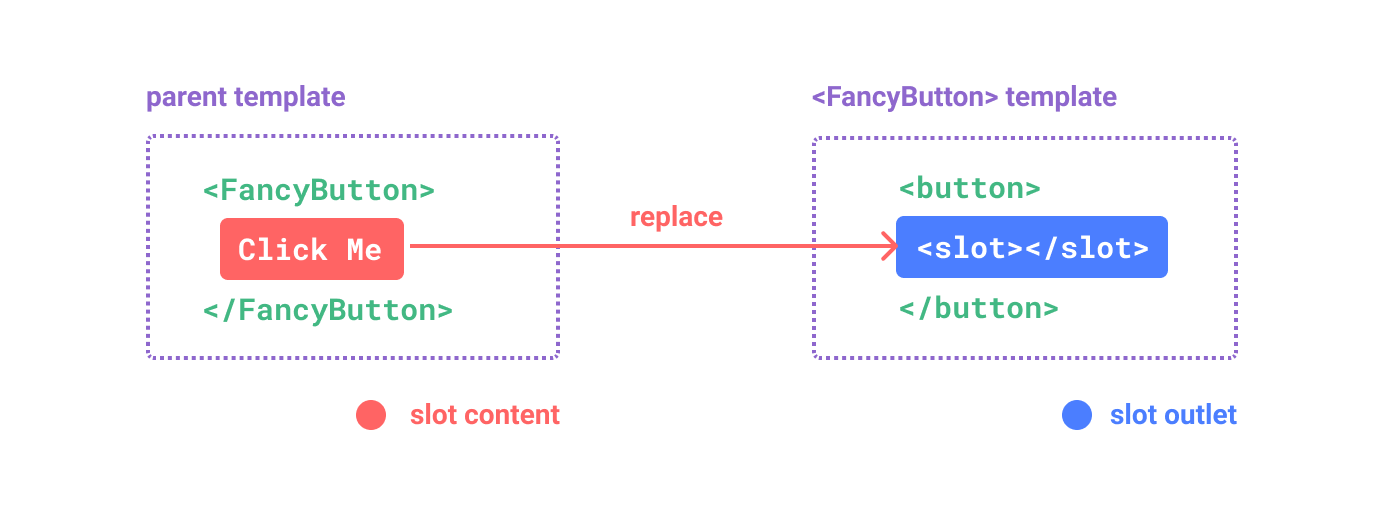

与props传递数据一样，slot传递“模板”也可用函数传参来理解: slot content是实参，slot outlet是形参
```js
// parent component passing slot content
FancyButton('Click me!')

// FancyButton renders slot content in its own template
function FancyButton(slotContent) {
  return (
    `<button class="fancy-btn">
      ${slotContent} 
    </button>`
  )
}
```

上面传递的是文本，实际上可以传递任意有效的“模板”

```html
<FancyButton>
  <span style="color:red">Click me!</span>
  {{message}}
</FancyButton>
```

注意：slot content是定义在父组件中的，可以访问父组件的数据，不能访问子组件（FancyButton)的数据

> Everything in the parent template is compiled in parent scope; everything in the child template is compiled in the child scope.

形参slot outlet可以有默认值
```html
<!-- SubmitButton 的模板  -->
<button type="submit">
  <slot>
    Submit <!-- fallback content -->
  </slot>
</button>
```

可以有多个slot outlet, 需要带名字来区分，不带名字的那个名为“default"

```html
<div class="container">
  <header>
    <slot name="header"></slot>
  </header>
  <main>
    <slot></slot>
  </main>
  <footer>
    <slot name="footer"></slot>
  </footer>
</div>
```

相应的slot content需用`<template v-slot:slotName></template>`来包裹

```html
<BaseLayout>
  <template v-slot:header>
    <!-- content for the header slot -->
  </template>
</BaseLayout>
```
无`<template>`包裹的部分，会传递给无名字的slot outlet
```html
<BaseLayout>
  <template #header>
    <h1>Here might be a page title</h1>
  </template>

  <!-- implicit default slot -->
  <p>A paragraph for the main content.</p>
  <p>And another one.</p>

  <template #footer>
    <p>Here's some contact info</p>
  </template>
</BaseLayout>
```

`v-slot:slotName`可以简写为`#slotName`

```html
<BaseLayout>
  <template #header>
    <h1>Here might be a page title</h1>
  </template>

  <template #default>
    <p>A paragraph for the main content.</p>
    <p>And another one.</p>
  </template>

  <template #footer>
    <p>Here's some contact info</p>
  </template>
</BaseLayout>
```

`slotName`可以是动态的
```html
<base-layout>
  <template v-slot:[dynamicSlotName]>
    ...
  </template>

  <!-- with shorthand -->
  <template #[dynamicSlotName]>
    ...
  </template>
</base-layout>
```

前面说过，slot content只能访问父组件的数据，不能访问子组件的数据

实际上，有的时候需要将子组件的slot outlet数据传递给父组件的slot content: 通过slot outlet的 `<slot>`标签html attributes来传递
```html
<!-- <MyComponent> template -->
<div>
  <slot :text="greetingMessage" :count="1"></slot>
</div>

<!-- 父组件 -->
<MyComponent v-slot="slotProps">
  {{ slotProps.text }} {{ slotProps.count }}
</MyComponent>
```

父组件中通过`v-slot=`来接收，注意区分前面的`v-slot:`

<div class="alert alert-block alert-danger">传统的函数传参是单方向的，函数调用传递数据给函数定义，但是前面的数据传递为什么是反的？</div>

可以理解为传递的是一个函数

```js
MyComponent({
  // passing the default slot, but as a function
  default: (slotProps) => {
    return `${slotProps.text} ${slotProps.count}`
  }
})

function MyComponent(slots) {
  const greetingMessage = 'hello'
  return (
    `<div>${
      // call the slot function with props!
      slots.default({ text: greetingMessage, count: 1 })
    }</div>`
  )
}
```

多个slot传递，也可以这样传递html attributes
```html
<MyComponent>
  <template #header="headerProps">
    {{ headerProps }}
  </template>

  <template #default="defaultProps">
    {{ defaultProps }}
  </template>

  <template #footer="footerProps">
    {{ footerProps }}
  </template>
</MyComponent>
```

# Provide/inject
在一个嵌套比较深的结构中，某个高层节点要传递数据给它的一个较深的节点，需要让中间的所有节点都传递一下。

也就是说，在每个中间组件中都要定义相应的props来接收, 并且模板中要用html属性要发送，但是每个中间节点又用不到这些数据

这种现象称作为props drilling（打孔）：可以比喻成一栋高楼中的有线网络，高层房间要发条信息给低层房间，需要在每层房间的天花板上打孔接线，由于中间层有可能也需要接收信息，所以每层都要有一个节点用来接收和发射

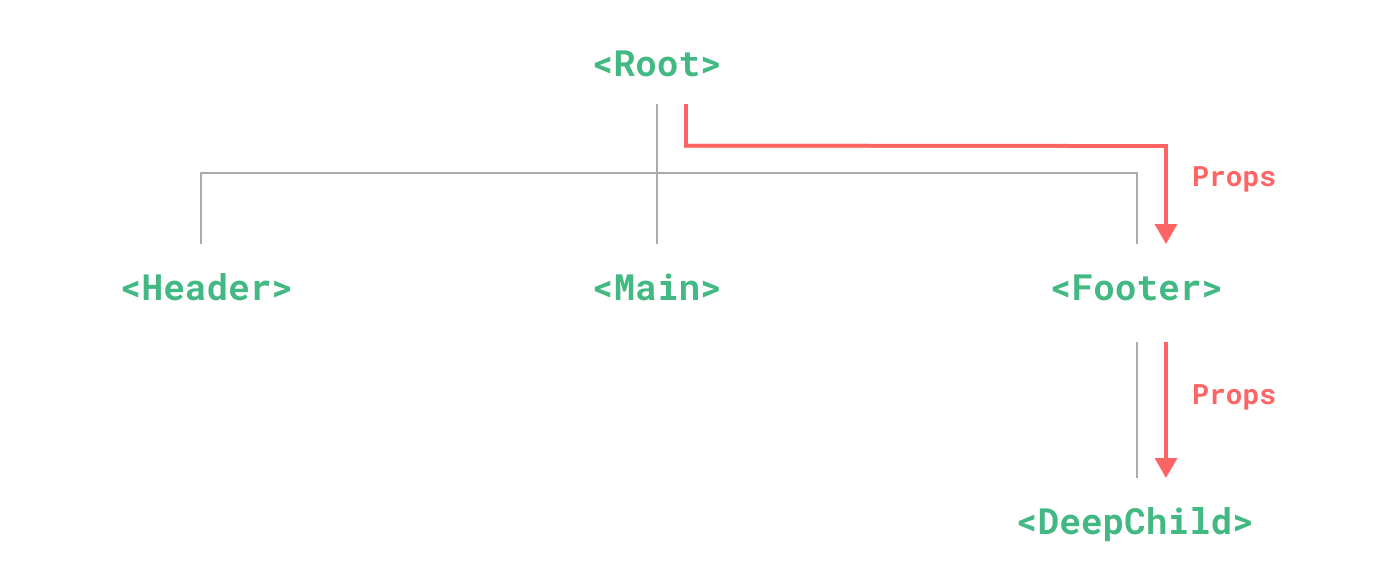

Vue提供了Provide/inject来解决props drilling问题：在高层装一个无线发射器(provide), 在每个有需要的低层装一个接收器(inject)
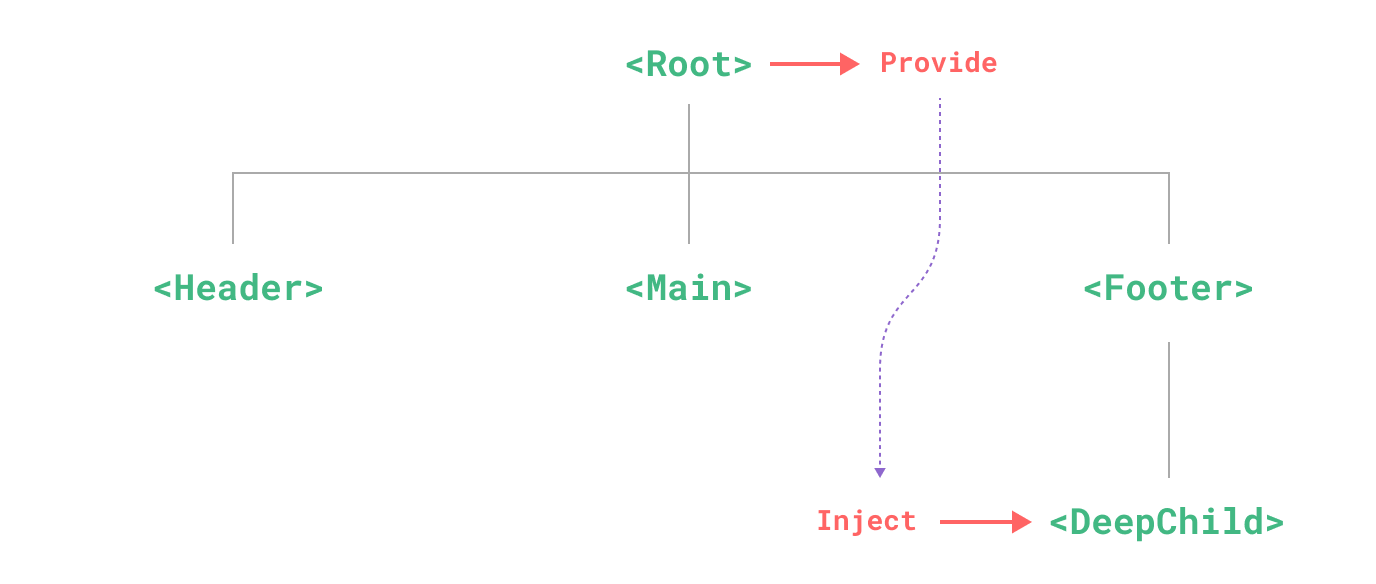

## Provide
使用provide选项来“发射”一个数据
```js
export default {
  provide: {
    message: 'hello!'
  }
}
```
若是想要不同实例发射不同的数据，则需要用函数形式（注意：这不会使得inject变成响应式)
```js
export default {
  data() {
    return {
      message: 'hello!'
    }
  },
  provide() {
    // use function syntax so that we can access `this`
    return {
      message: this.message
    }
  }
}
```

也可以从app顶层”发射“：整个app内部都可以接收
```js
import { createApp } from 'vue'

const app = createApp({})

app.provide(/* key */ 'message', /* value */ 'hello!')
```

## Inject
后代组件使用`inject`选项来接收

```js
export default {
  inject: ['message'],
  created() {
    console.log(this.message) // injected value
  }
}
```

接收数据是在自身状态数据构造之前，因此可以使用inject数据来初始化组件状态

```js
export default {
  inject: ['message'],
  data() {
    return {
      // initial data based on injected value
      fullMessage: this.message
    }
  }
}
```

使用array语法接收到的数据是使用发射时的名字，若想换个名字，需要用object语法
```js
export default {
  inject: {
    /* local key */ localMessage: {
      from: /* injection key */ 'message'
    }
  }
}
```
object语法还可以设置默认值

```js
export default {
  // object syntax is required
  // when declaring default values for injections
  inject: {
    message: {
      from: 'message', // this is optional if using the same key for injection
      default: 'default value'
    },
    user: {
      // use a factory function for non-primitive values that are expensive
      // to create, or ones that should be unique per component instance.
      default: () => ({ name: 'John' })
    }
  }
}
```

若想要injection接收的数据有”响应性“，可以使用`computed` 函数（组合式API）

```js
import { computed } from 'vue'

export default {
  data() {
    return {
      message: 'hello!'
    }
  },
  provide() {
    return {
      // explicitly provide a computed property
      message: computed(() => this.message)
    }
  }
}
```

# 异步组件(Async Component)
程序较大时，可能需要”按需“导入组件

```js
import { defineAsyncComponent } from 'vue'

const AsyncComp = defineAsyncComponent(() => {
  return new Promise((resolve, reject) => {
    // ...load component from server
    resolve(/* loaded component */)
  })
})
```
可以使用es module的动态import
```js
import { defineAsyncComponent } from 'vue'

const AsyncComp = defineAsyncComponent(() =>
  import('./components/MyComponent.vue')
)
```


```js
import { defineAsyncComponent } from 'vue'

export default {
  // ...
  components: {
    AsyncComponent: defineAsyncComponent(() =>
      import('./components/AsyncComponent.vue')
    )
  }
}
```

异步加载和错误
```js
const AsyncComp = defineAsyncComponent({
  // the loader function
  loader: () => import('./Foo.vue'),

  // A component to use while the async component is loading
  loadingComponent: LoadingComponent,
  // Delay before showing the loading component. Default: 200ms.
  delay: 200,

  // A component to use if the load fails
  errorComponent: ErrorComponent,
  // The error component will be displayed if a timeout is
  // provided and exceeded. Default: Infinity.
  timeout: 3000
})
```

参考：Vue async components: [英文](https://vuejs.org/guide/components/async.html)